In [1]:
import numpy as np 
import matplotlib as mp
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.slim as slim
import math
from __future__ import print_function
import os
from io import BytesIO
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML

# 1. Load pretrained vgg16 model

In [2]:
# %load vgg16
########################################################################################
# Davi Frossard, 2016                                                                  #
# VGG16 implementation in TensorFlow                                                   #
# Details:                                                                             #
# http://www.cs.toronto.edu/~frossard/post/vgg16/                                      #
#                                                                                      #
# Model from https://gist.github.com/ksimonyan/211839e770f7b538e2d8#file-readme-md     #
# Weights from Caffe converted using https://github.com/ethereon/caffe-tensorflow      #
########################################################################################

#import tensorflow as tf
#import numpy as np
from scipy.misc import imread, imresize
from imagenet_classes import class_names


class vgg16:
    def __init__(self, imgs, weights=None, sess=None):
        self.imgs = imgs
        self.convlayers()
        self.fc_layers()
        self.probs = tf.nn.softmax(self.fc3l)
        
        ##############################################
        ### add value variables in the original code 
        ### we want to extract these layers later for filter visualization
        self.value53 = self.conv5_3
        self.value51 = self.conv5_1
        self.value41 = self.conv4_1
        self.value31 = self.conv3_1
        self.value21 = self.conv2_1
        self.value11 = self.conv1_1
        
        
        
        if weights is not None and sess is not None:
            self.load_weights(weights, sess)


    def convlayers(self):
        self.parameters = []

        # zero-mean input
        with tf.name_scope('preprocess') as scope:
            mean = tf.constant([123.68, 116.779, 103.939], dtype=tf.float32, shape=[1, 1, 1, 3], name='img_mean')
            images = self.imgs-mean

        # conv1_1
        with tf.name_scope('conv1_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 3, 64], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(images, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv1_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv1_2
        with tf.name_scope('conv1_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 64, 64], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv1_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv1_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool1
        self.pool1 = tf.nn.max_pool(self.conv1_2,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool1')

        # conv2_1
        with tf.name_scope('conv2_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 64, 128], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv2_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv2_2
        with tf.name_scope('conv2_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 128, 128], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv2_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv2_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool2
        self.pool2 = tf.nn.max_pool(self.conv2_2,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool2')

        # conv3_1
        with tf.name_scope('conv3_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 128, 256], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv3_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv3_2
        with tf.name_scope('conv3_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 256], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv3_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv3_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv3_3
        with tf.name_scope('conv3_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 256], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv3_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv3_3 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool3
        self.pool3 = tf.nn.max_pool(self.conv3_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool3')

        # conv4_1
        with tf.name_scope('conv4_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool3, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv4_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv4_2
        with tf.name_scope('conv4_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv4_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv4_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv4_3
        with tf.name_scope('conv4_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv4_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv4_3 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool4
        self.pool4 = tf.nn.max_pool(self.conv4_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool4')

        # conv5_1
        with tf.name_scope('conv5_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool4, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv5_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv5_2
        with tf.name_scope('conv5_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv5_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv5_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv5_3
        with tf.name_scope('conv5_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv5_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv5_3 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool5
        self.pool5 = tf.nn.max_pool(self.conv5_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool4')

    def fc_layers(self):
        # fc1
        with tf.name_scope('fc1') as scope:
            shape = int(np.prod(self.pool5.get_shape()[1:]))
            fc1w = tf.Variable(tf.truncated_normal([shape, 4096],
                                                         dtype=tf.float32,
                                                         stddev=1e-1), name='weights')
            fc1b = tf.Variable(tf.constant(1.0, shape=[4096], dtype=tf.float32),
                                 trainable=True, name='biases')
            pool5_flat = tf.reshape(self.pool5, [-1, shape])
            fc1l = tf.nn.bias_add(tf.matmul(pool5_flat, fc1w), fc1b)
            self.fc1 = tf.nn.relu(fc1l)
            self.parameters += [fc1w, fc1b]

        # fc2
        with tf.name_scope('fc2') as scope:
            fc2w = tf.Variable(tf.truncated_normal([4096, 4096],
                                                         dtype=tf.float32,
                                                         stddev=1e-1), name='weights')
            fc2b = tf.Variable(tf.constant(1.0, shape=[4096], dtype=tf.float32),
                                 trainable=True, name='biases')
            fc2l = tf.nn.bias_add(tf.matmul(self.fc1, fc2w), fc2b)
            self.fc2 = tf.nn.relu(fc2l)
            self.parameters += [fc2w, fc2b]

        # fc3
        with tf.name_scope('fc3') as scope:
            fc3w = tf.Variable(tf.truncated_normal([4096, 1000],
                                                         dtype=tf.float32,
                                                         stddev=1e-1), name='weights')
            fc3b = tf.Variable(tf.constant(1.0, shape=[1000], dtype=tf.float32),
                                 trainable=True, name='biases')
            self.fc3l = tf.nn.bias_add(tf.matmul(self.fc2, fc3w), fc3b)
            self.parameters += [fc3w, fc3b]

    def load_weights(self, weight_file, sess):
        weights = np.load(weight_file)
        keys = sorted(weights.keys())
        for i, k in enumerate(keys):
            #print (i, k, np.shape(weights[k]))
            sess.run(self.parameters[i].assign(weights[k]))



## 1.1 View the graph on tensorboard

In [3]:
# creating TensorFlow session and loading the model
with tf.Session() as sess:
    imgs = tf.placeholder(tf.float32, [None, 224, 224, 3])
    vgg = vgg16(imgs, 'vgg16_weights.npz', sess)
    
    # write file for tensorboard of model vgg16
    #summary_writer = tf.summary.FileWriter('logs', sess.graph)
    
    img1 = imread('laska.png', mode='RGB')
    img1 = imresize(img1, (224, 224))
    
    #feed with img1, get layer conv2_
    units11 = sess.run(vgg.value11, feed_dict={vgg.imgs: [img1]})[0]
    units21 = sess.run(vgg.value21, feed_dict={vgg.imgs: [img1]})[0]
    units31 = sess.run(vgg.value31, feed_dict={vgg.imgs: [img1]})[0]
    units41 = sess.run(vgg.value41, feed_dict={vgg.imgs: [img1]})[0]
    units51 = sess.run(vgg.value51, feed_dict={vgg.imgs: [img1]})[0]

/Users/zhaojing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':
/Users/zhaojing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


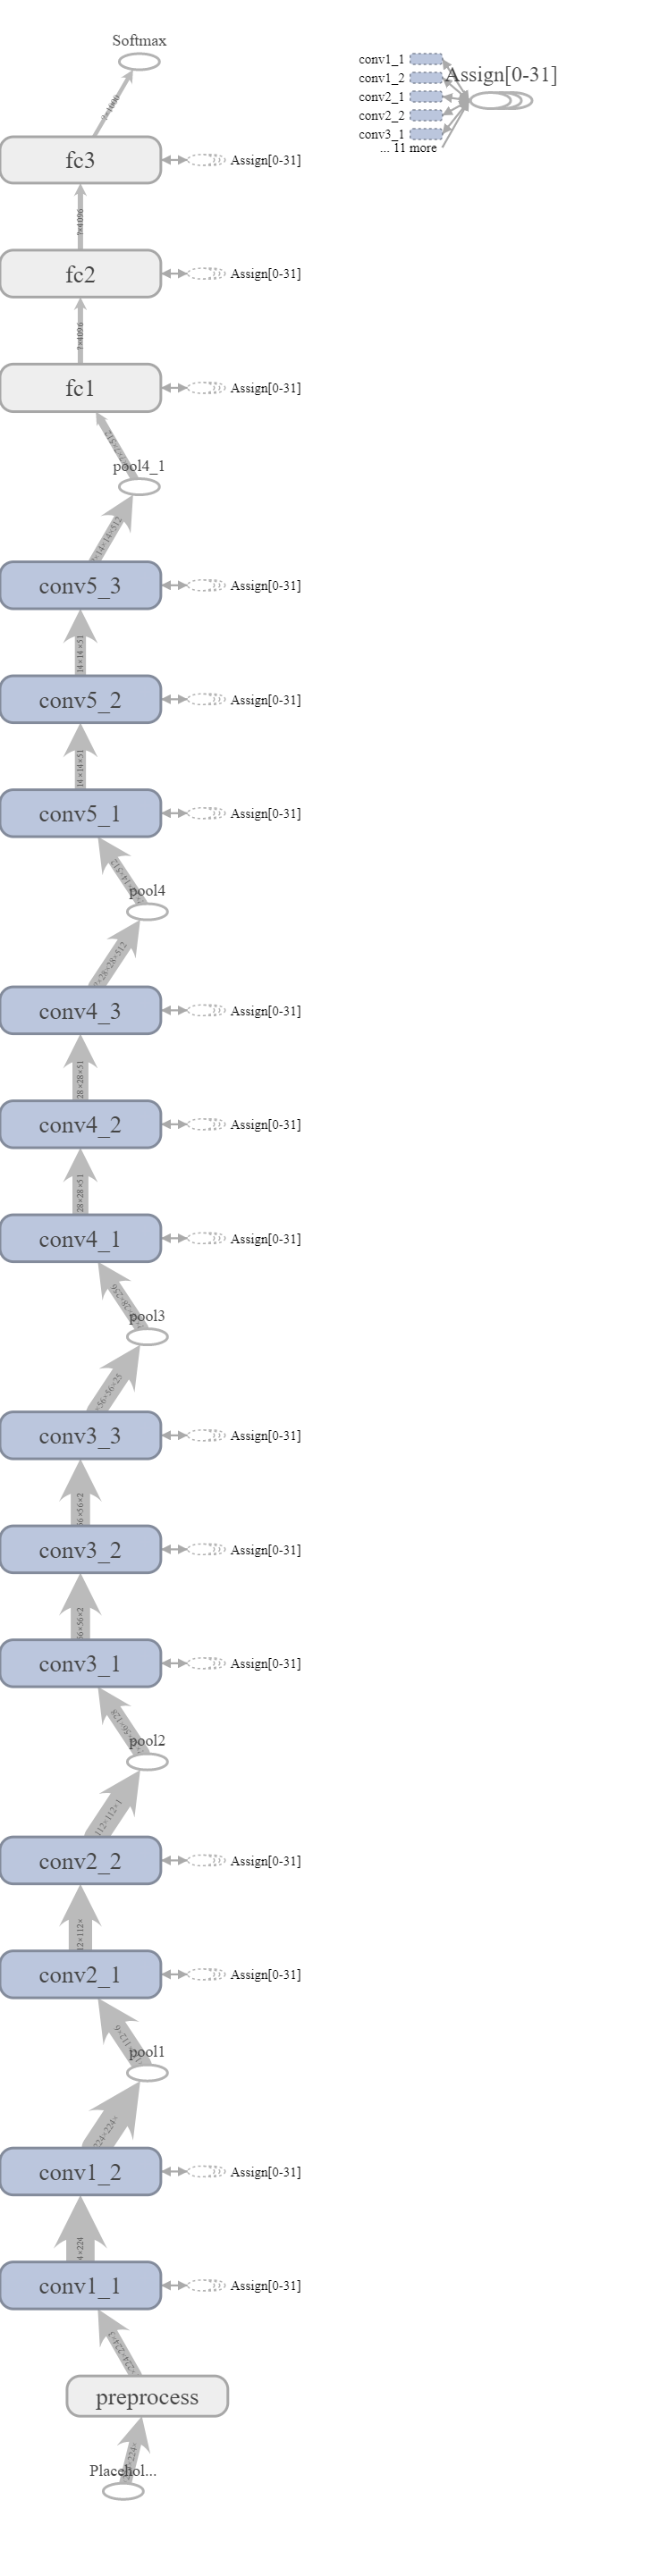

In [5]:
# Vgg16 on tensorboard with 13 convolutional layers.
Image('vgg16_tensorboard.png')

## 1.2 Filter Activation

In [6]:
# Write helper function to visualize any 5 connected filters among total of 128 in our model
def plot_filter(units, F_start):
    #get the total number of filters
    filters = units.shape[2]   
    #build the subplots frame
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    
    for i in range(filters)[F_start:F_start+5]:
        ax = axes.flat[i-F_start]
        ax.set_xlabel("Filter " + str(i))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(units[:,:,i], interpolation="nearest", cmap="gray")
    f = ax.get_figure()
    f.savefig("output.png")

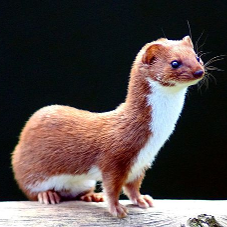

In [7]:
#The original picture
Image('laska.png')

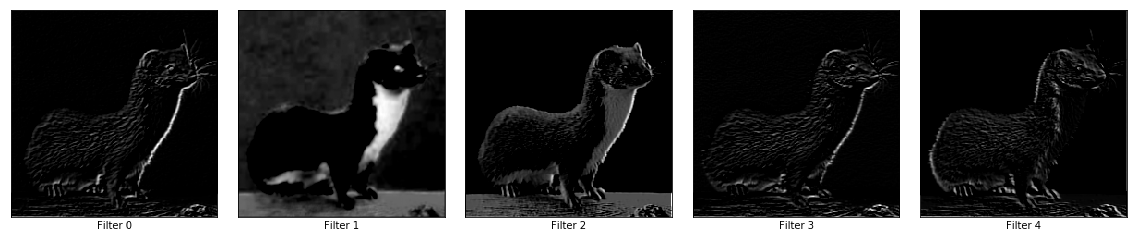

In [8]:
plot_filter(units11,0)

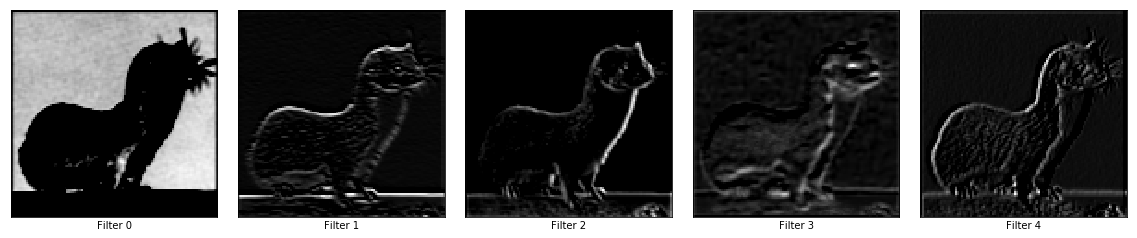

In [9]:
plot_filter(units21,0)

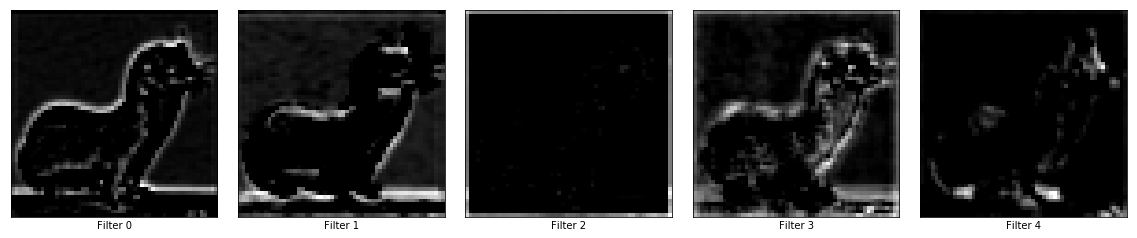

In [10]:
plot_filter(units31,0)

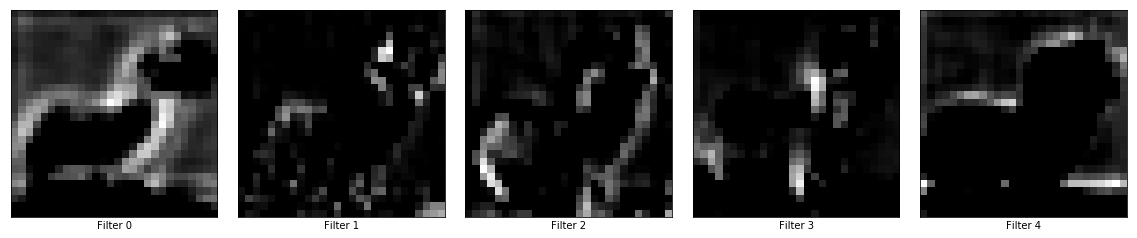

In [11]:
plot_filter(units41,0)

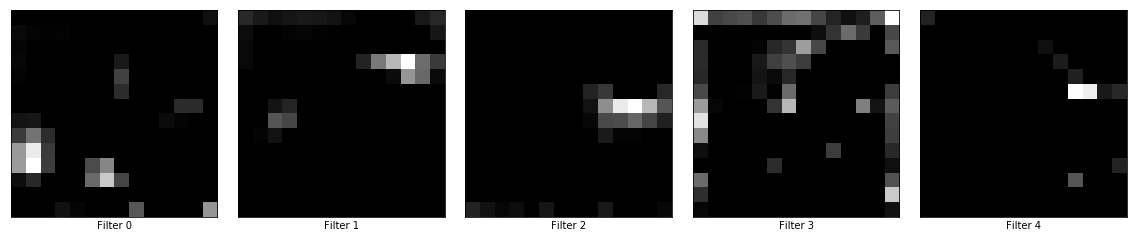

In [12]:
plot_filter(units51,0)

# 2. Naive feature visualization

In [13]:
# View tensors in the graph
op = sess.graph.get_operations()
[m.values() for m in op]

[(<tf.Tensor 'Placeholder:0' shape=(?, 224, 224, 3) dtype=float32>,),
 (<tf.Tensor 'preprocess/img_mean:0' shape=(1, 1, 1, 3) dtype=float32>,),
 (<tf.Tensor 'preprocess/sub:0' shape=(?, 224, 224, 3) dtype=float32>,),
 (<tf.Tensor 'conv1_1/truncated_normal/shape:0' shape=(4,) dtype=int32>,),
 (<tf.Tensor 'conv1_1/truncated_normal/mean:0' shape=() dtype=float32>,),
 (<tf.Tensor 'conv1_1/truncated_normal/stddev:0' shape=() dtype=float32>,),
 (<tf.Tensor 'conv1_1/truncated_normal/TruncatedNormal:0' shape=(3, 3, 3, 64) dtype=float32>,),
 (<tf.Tensor 'conv1_1/truncated_normal/mul:0' shape=(3, 3, 3, 64) dtype=float32>,),
 (<tf.Tensor 'conv1_1/truncated_normal:0' shape=(3, 3, 3, 64) dtype=float32>,),
 (<tf.Tensor 'conv1_1/weights:0' shape=(3, 3, 3, 64) dtype=float32_ref>,),
 (<tf.Tensor 'conv1_1/weights/Assign:0' shape=(3, 3, 3, 64) dtype=float32_ref>,),
 (<tf.Tensor 'conv1_1/weights/read:0' shape=(3, 3, 3, 64) dtype=float32>,),
 (<tf.Tensor 'conv1_1/Conv2D:0' shape=(?, 224, 224, 64) dtype=flo

In [14]:
# helper functions quote from deepdream  
# DeepDreaming with TensorFlow                                                                                                                  #
# code source:                                                                             
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb                                   
##############################################################################################################
 
def img_norm(img, s=0.1):
    '''Normalize the image range for visualization'''
    cal_ = (img-img.mean())/max(img.std(), 1e-4)
    res = cal_*s + 0.5
    return res

def T(layer):
    '''Helper for getting layer output tensor'''
    return sess.graph.get_tensor_by_name(layer)

In [15]:
# start with a gray image with a little noise
img_noise = np.random.uniform(size=(224,224,3)) + 100.0

def naive_grad(obj_tensor, img=img_noise, iterations=50, step_size=3.0):
    '''realize the gradent ascent method '''
    ## input:  t_obj: tensor of we want to optimize
    ##         img0:  initial input image to start with
    ##         iter_n: number of iterations
    ##         step: gradient learning rate
    ## output: visualization for the input layer tensor with chosen feature
    img1 = img.copy()
    obj_los = tf.reduce_mean(obj_tensor) 
    grad = tf.gradients(obj_los, vgg.imgs)[0] # differentiate objective with input vgg.imgs 
    for i in range(iterations):
        g = sess.run(grad, {vgg.imgs:[img1]})
        g /= g.std()+1e-8  
        img1 += g[-1,:,:,:]*step_size 
    return(img1)

In [21]:
with tf.Graph().as_default():
    sess = tf.Session()
    imgs = tf.placeholder(tf.float32, [None, 224, 224, 3])
    vgg = vgg16(imgs, 'vgg16_weights.npz', sess)
    # conv1
    layer = 'conv1_1/Conv2D:0'
    conv1_naive = naive_grad(T(layer)[:,:,:,1])
    img_array = np.uint8(np.clip(img_norm(conv1_naive), 0, 1)*255)
    PIL.Image.fromarray(img_array).save('conv1_1_naive.jpeg')
    # conv2
    layer = 'conv2_1/Conv2D:0'
    conv2_naive = naive_grad(T(layer)[:,:,:,1])
    img_array = np.uint8(np.clip(img_norm(conv2_naive), 0, 1)*255)
    PIL.Image.fromarray(img_array).save('conv2_1_naive.jpeg')
    #conv3
    layer = 'conv3_1/Conv2D:0'
    conv3_naive = naive_grad(T(layer)[:,:,:,1])
    img_array = np.uint8(np.clip(img_norm(conv3_naive), 0, 1)*255)
    PIL.Image.fromarray(img_array).save('conv3_1_naive.jpeg')
    #conv4
    layer = 'conv4_1/Conv2D:0'
    conv4_naive = naive_grad(T(layer)[:,:,:,1])
    img_array = np.uint8(np.clip(img_norm(conv4_naive), 0, 1)*255)
    PIL.Image.fromarray(img_array).save('conv4_1_naive.jpeg')
    #conv5
    layer = 'conv5_1/Conv2D:0'
    conv5_naive = naive_grad(T(layer)[:,:,:,1])
    img_array = np.uint8(np.clip(img_norm(conv5_naive), 0, 1)*255)
    PIL.Image.fromarray(img_array).save('conv5_1_naive.jpeg')
    #fc3
    layer = 'fc3/BiasAdd:0'
    fc3_naive = naive_grad(T(layer)[:,130])
    img_array = np.uint8(np.clip(img_norm(fc3_naive), 0, 1)*255)
    PIL.Image.fromarray(img_array).save('fc3_naive.jpeg')

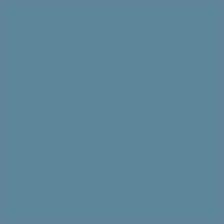

In [22]:
Image('conv1_1_naive.jpeg')

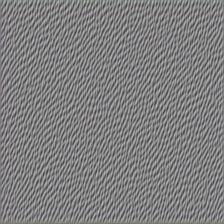

In [23]:
Image('conv2_1_naive.jpeg')

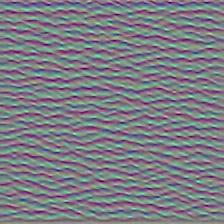

In [24]:
Image('conv3_1_naive.jpeg')

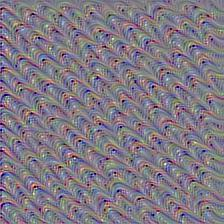

In [25]:
Image('conv4_1_naive.jpeg')

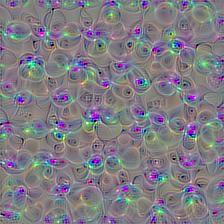

In [26]:
Image('conv5_1_naive.jpeg')

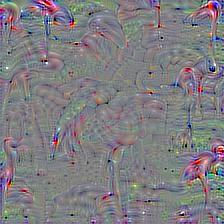

In [27]:
Image('fc3_naive.jpeg')

# 3. Regularization 

- clip 
- decay
- blur
- clip with small norm

In [28]:
# clip
## zero-mean input
mean_value = np.array([123.68, 116.779, 103.939]).reshape((1,1,3))
noiseImg = np.clip(img_noise, 0.-mean_value, 255.-mean_value)

In [29]:
# L2 Decay
l2decay = 0.5
img_decay = noiseImg
img_decay *= (1 - l2decay) 

In [30]:
# gaussian blur
from scipy.ndimage.filters import gaussian_filter
StDev = 0.3
img_blur = gaussian_filter(img_decay, sigma=[StDev, StDev, 0])

In [31]:
# clips with small norm
from numpy.linalg import norm 
from numpy import newaxis, percentile, tile
small_norm_percentile = 0.2
img_clip_norm = img_blur[newaxis,:]
img_norms = norm(img_clip_norm, axis=3)
img_bool = img_norms < percentile(img_norms, small_norm_percentile)
img_bool3 = tile(img_bool[:,:,:,newaxis], (1,1,1,3))
img_clip_norm_ = img_clip_norm - img_clip_norm*img_bool3
img_clip_norm = img_clip_norm_[-1,:,:,:]

In [32]:
with tf.Graph().as_default():
    sess = tf.Session()
    imgs = tf.placeholder(tf.float32, [None, 224, 224, 3])
    vgg = vgg16(imgs, 'vgg16_weights.npz', sess)
    layer = 'fc3/BiasAdd:0'
    #clip
    fc3_clip = naive_grad(T(layer)[:,130],img = noiseImg)
    img_array = np.uint8(np.clip(img_norm(fc3_clip), 0, 1)*255)
    PIL.Image.fromarray(img_array).save('fc3_clip.jpeg')
    #decay
    fc3_decay = naive_grad(T(layer)[:,130],img = img_decay)
    img_array = np.uint8(np.clip(img_norm(fc3_decay), 0, 1)*255)
    PIL.Image.fromarray(img_array).save('fc3_decay.jpeg')
    #blur
    fc3_blur = naive_grad(T(layer)[:,130],img = img_blur)
    img_array = np.uint8(np.clip(img_norm(fc3_blur), 0, 1)*255)
    PIL.Image.fromarray(img_array).save('fc3_blur.jpeg')
    #clip with small norm
    fc3_small_norm = naive_grad(T(layer)[:,130],img = img_clip_norm)
    img_array = np.uint8(np.clip(img_norm(fc3_small_norm), 0, 1)*255)
    PIL.Image.fromarray(img_array).save('fc3_small_norm.jpeg')

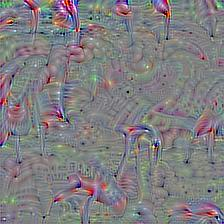

In [33]:
Image('fc3_clip.jpeg')

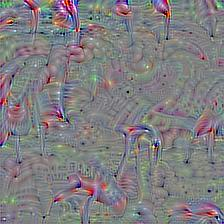

In [34]:
Image('fc3_decay.jpeg')

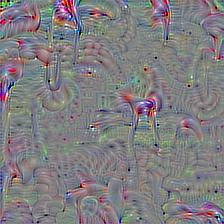

In [35]:
Image('fc3_blur.jpeg')

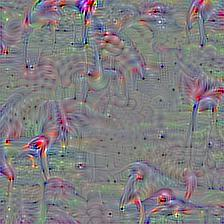

In [36]:
Image('fc3_small_norm.jpeg')

## 4. Improved gradient way
* 4.1 Gradient Blur

In [37]:
def saveImage(image, name):
    img_array = np.uint8(np.clip(img_norm(image), 0, 1)*255)
    PIL.Image.fromarray(img_array).save(name + '.jpeg')

In [40]:
def gradient_blur(obj_tensor, image = img_clip_norm, iterations=50, step_size=3.0, visual_gradient = False):
    img1 = image.copy()
    obj_los = tf.reduce_mean(obj_tensor)
    obj_grad = tf.gradients(obj_los, vgg.imgs)[0] 
    
    for i in range(iterations):
        g = sess.run(obj_grad, {vgg.imgs:[img1]})
        g /= g.std()+1e-8         
        grad = g[-1,:,:,:]
        sigma = (i * 4.0) / iterations + 0.5
        grad_smooth1 = gaussian_filter(grad, sigma=sigma)
        grad_smooth2 = gaussian_filter(grad, sigma=sigma*2)
        grad_smooth3 = gaussian_filter(grad, sigma=sigma*0.5)
        grad = (grad_smooth1 + grad_smooth2 + grad_smooth3)
        step_size_1 = step_size / (np.std(grad) + 1e-8)
        img1 += grad * step_size_1
        if visual_gradient:
            saveImage(grad, 'grad_'+str(i))
            print('Visualize Gradient at Iteration' + str(i) + ' Saved')
    print()
    saveImage(img1, 'optimize_image')
    print("ALL DONE")

In [41]:
with tf.Graph().as_default():
    if __name__ == '__main__':
        sess = tf.Session()
        imgs = tf.placeholder(tf.float32, [None, 224, 224, 3])
        vgg = vgg16(imgs, 'vgg16_weights.npz', sess)
        layer = 'fc3/BiasAdd:0'
        gradient_blur(T(layer)[:,130])
        Image('optimize_image' + '.jpeg')


ALL DONE


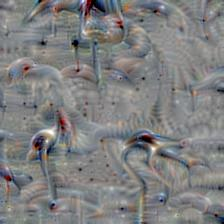

In [42]:
Image('optimize_image.jpeg')

* 4.2 Recursive Computing

In [43]:
def gradient_blur_1(obj_tensor, repeats, image = img_clip_norm, iterations=50, step_size=3.0):
    img1 = image.copy()
    obj_los = tf.reduce_mean(obj_tensor)
    obj_grad = tf.gradients(obj_los, vgg.imgs)[0] 
    
    for i in range(iterations):
        g = sess.run(obj_grad, {vgg.imgs:[img1]})
        g /= g.std()+1e-8         
        grad = g[-1,:,:,:]
        sigma = (i * 4.0) / iterations + 0.5
        grad_smooth1 = gaussian_filter(grad, sigma=sigma)
        grad_smooth2 = gaussian_filter(grad, sigma=sigma*2)
        grad_smooth3 = gaussian_filter(grad, sigma=sigma*0.5)
        grad = (grad_smooth1 + grad_smooth2 + grad_smooth3)
        step_size_1 = step_size / (np.std(grad) + 1e-8)
        img1 += grad * step_size_1
        
    saveImage(img1, 'optimize_image'+ str(repeats))
    print('Repeat' + str(repeats)+ 'DONE')
    
    return img1

In [50]:
def recursive_computing(obj_tensor, image = img_clip_norm, repeats=4, mixture=0.3,iterations=10, step_size=3.0):

    img1 = image.copy()
    if repeats>0:
        sigma = 0.3
        img_blur = gaussian_filter(img1, sigma=(sigma, sigma, 0.0))
        img_after = recursive_computing(obj_tensor=obj_tensor,image=img_blur,repeats=repeats-1,mixture=mixture,
                                        iterations=iterations,step_size=step_size)
        image = mixture * img1 + (1.0 - mixture) * img_after
    print("Recursive level:", repeats)
    img_after = gradient_blur_1(obj_tensor=obj_tensor,repeats = repeats,image=image,iterations=iterations,
                                step_size=step_size)
    
    return img_after



In [51]:
with tf.Graph().as_default():
    if __name__ == '__main__':
        sess = tf.Session()
        imgs = tf.placeholder(tf.float32, [None, 224, 224, 3])
        vgg = vgg16(imgs, 'vgg16_weights.npz', sess)
        layer = 'fc3/BiasAdd:0'
        recursive_computing(T(layer)[:,130])

Recursive level: 0
Repeat0DONE
Recursive level: 1
Repeat1DONE
Recursive level: 2
Repeat2DONE
Recursive level: 3
Repeat3DONE
Recursive level: 4
Repeat4DONE


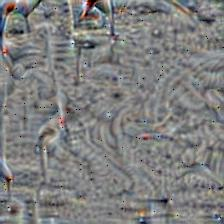

In [52]:
Image('optimize_image0.jpeg')

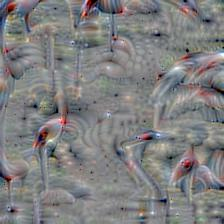

In [53]:
Image('optimize_image4.jpeg')

* 4.3 Laplacian Pyramid Decomposition

In [54]:
# helper functions quote from deepdream  
# DeepDreaming with TensorFlow                                                                                                                  #
# code source:                                                                             
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb                                   
##############################################################################################################

k = np.float32([1,4,6,4,1])
k = np.outer(k, k)
k5x5 = k[:,:,None,None]/k.sum()*np.eye(3, dtype=np.float32)

def lap_split(img):
    '''Split the image into lo and hi frequency components'''
    with tf.name_scope('split'):
        lo = tf.nn.conv2d(img, k5x5, [1,2,2,1], 'SAME')
        lo2 = tf.nn.conv2d_transpose(lo, k5x5*4, tf.shape(img), [1,2,2,1])
        hi = img-lo2
    return lo, hi

def lap_split_n(img, n):
    '''Build Laplacian pyramid with n splits'''
    levels = []
    for i in range(n):
        img, hi = lap_split(img)
        levels.append(hi)
    levels.append(img)
    return levels[::-1]

def lap_merge(levels):
    '''Merge Laplacian pyramid'''
    img = levels[0]
    for hi in levels[1:]:
        with tf.name_scope('merge'):
            img = tf.nn.conv2d_transpose(img, k5x5*4, tf.shape(hi), [1,2,2,1]) + hi
    return img

def normalize_std(img, eps=1e-10):
    '''Normalize image by making its standard deviation = 1.0'''
    with tf.name_scope('normalize'):
        std = tf.sqrt(tf.reduce_mean(tf.square(img)))
        return img/tf.maximum(std, eps)

def lap_normalize(img, scale_n=4):
    '''Perform the Laplacian pyramid normalization.'''
    img = tf.expand_dims(img,0)
    tlevels = lap_split_n(img, scale_n)
    tlevels = list(map(normalize_std, tlevels))
    out = lap_merge(tlevels)
    return out[0,:,:,:]

lap_graph = tf.Graph()
with lap_graph.as_default():
    lap_in = tf.placeholder(np.float32, name='lap_in')
    lap_out = lap_normalize(lap_in)

In [55]:
def tffunc(*argtypes):
    '''Helper that transforms TF-graph generating function into a regular one.
    See "resize" function below.
    '''
    placeholders = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            with sess.as_default():
                return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
        return wrapper
    return wrap

# Helper function that uses TF to resize an image
def resize(img, size):
    img = tf.expand_dims(img, 0)
    return tf.image.resize_bilinear(img, size)[0,:,:,:]
resize = tffunc(np.float32, np.int32)(resize)



In [56]:
def laplacian_optim(obj_tensor, lap_n, image = img_clip_norm, iterations = 50, step_size=3.0):
    img = image.copy()
    obj_los = tf.reduce_mean(obj_tensor) 
    obj_grad = tf.gradients(obj_los, vgg.imgs)[0] 
    
    lap_norm_func = tffunc(np.float32)(partial(lap_normalize, scale_n=lap_n))
    
    for i in range(iterations):
        g = sess.run(obj_grad, {vgg.imgs:[img]})
        g /= np.std(g)+1e-8
        g = g[-1,:,:,:]
        g = lap_norm_func(g)
        img += g*step_size
        print('Iteration ',i, 'Done')
        
    saveImage(img,'laplacian_lap_' + str(lap_n))

In [57]:
def laplacian_optim_combine(obj_tensor, image = img_clip_norm, iterations = 50, step_size=3.0, lap_n1=5, lap_n2 = 4):
    img = image.copy()
    obj_los = tf.reduce_mean(obj_tensor) 
    obj_grad = tf.gradients(obj_los, vgg.imgs)[0] 
    
    lap_norm_func = tffunc(np.float32)(partial(lap_normalize, scale_n=lap_n1))
    lap_norm_func1 = tffunc(np.float32)(partial(lap_normalize, scale_n=lap_n2))
    
    for i in range(iterations):
        g = sess.run(obj_grad, {vgg.imgs:[img]})
        g /= np.std(g)+1e-8
        g = g[-1,:,:,:]
        g1 = lap_norm_func(g)
        g2 = lap_norm_func1(g)
        step_size_1 = step_size / (np.std(g) + 1e-8)
        g3 = g1 + g2
        img += g3*step_size_1
        print('Iteration ',i, 'Done')
        
    saveImage(img,'laplacian')

In [58]:
with tf.Graph().as_default():
    sess = tf.Session()
    imgs = tf.placeholder(tf.float32, [None, 224, 224, 3])
    vgg = vgg16(imgs, 'vgg16_weights.npz', sess)
    layer = 'fc3/BiasAdd:0'
    laplacian_optim(T(layer)[:,130],lap_n = 4)
    laplacian_optim(T(layer)[:,130],lap_n = 5)
    laplacian_optim_combine(T(layer)[:,130])

Iteration  0 Done
Iteration  1 Done
Iteration  2 Done
Iteration  3 Done
Iteration  4 Done
Iteration  5 Done
Iteration  6 Done
Iteration  7 Done
Iteration  8 Done
Iteration  9 Done
Iteration  10 Done
Iteration  11 Done
Iteration  12 Done
Iteration  13 Done
Iteration  14 Done
Iteration  15 Done
Iteration  16 Done
Iteration  17 Done
Iteration  18 Done
Iteration  19 Done
Iteration  20 Done
Iteration  21 Done
Iteration  22 Done
Iteration  23 Done
Iteration  24 Done
Iteration  25 Done
Iteration  26 Done
Iteration  27 Done
Iteration  28 Done
Iteration  29 Done
Iteration  30 Done
Iteration  31 Done
Iteration  32 Done
Iteration  33 Done
Iteration  34 Done
Iteration  35 Done
Iteration  36 Done
Iteration  37 Done
Iteration  38 Done
Iteration  39 Done
Iteration  40 Done
Iteration  41 Done
Iteration  42 Done
Iteration  43 Done
Iteration  44 Done
Iteration  45 Done
Iteration  46 Done
Iteration  47 Done
Iteration  48 Done
Iteration  49 Done
Iteration  0 Done
Iteration  1 Done
Iteration  2 Done
Iterat

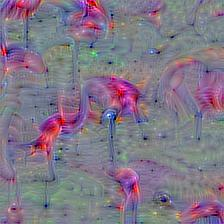

In [59]:
Image('laplacian_lap_4.jpeg')

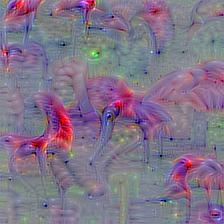

In [60]:
Image('laplacian_lap_5.jpeg')

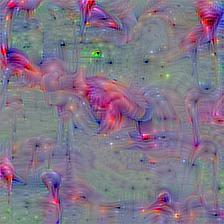

In [61]:
Image('laplacian.jpeg')